In [1]:
import pandas as pd

train_df = pd.read_csv('sent_train.csv')
valid_df = pd.read_csv('sent_valid.csv')

print(train_df.head())
print(train_df['label'].value_counts())  # 0: Bearish, 1: Bullish, 2: Neutral

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128)
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128)

In [3]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_df["label"].tolist())
valid_dataset = SentimentDataset(valid_encodings, valid_df["label"].tolist())

In [4]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs"
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=1).numpy()
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\22870\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.546900,0.352633,0.864322,0.866428
2,0.276300,0.356399,0.890285,0.888986
3,0.155200,0.528927,0.885678,0.885171


TrainOutput(global_step=1791, training_loss=0.28721342613948647, metrics={'train_runtime': 575.4698, 'train_samples_per_second': 49.749, 'train_steps_per_second': 3.112, 'total_flos': 1206404826099732.0, 'train_loss': 0.28721342613948647, 'epoch': 3.0})

In [5]:
# Evaluate using compute_metrics
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.5289266705513, 'eval_accuracy': 0.885678391959799, 'eval_f1': 0.8851711937564816, 'eval_runtime': 7.94, 'eval_samples_per_second': 300.756, 'eval_steps_per_second': 18.892, 'epoch': 3.0}


Classification Report:
               precision    recall  f1-score   support

     Bearish       0.80      0.80      0.80       347
     Bullish       0.85      0.81      0.83       475
     Neutral       0.91      0.93      0.92      1566

    accuracy                           0.89      2388
   macro avg       0.86      0.84      0.85      2388
weighted avg       0.88      0.89      0.89      2388



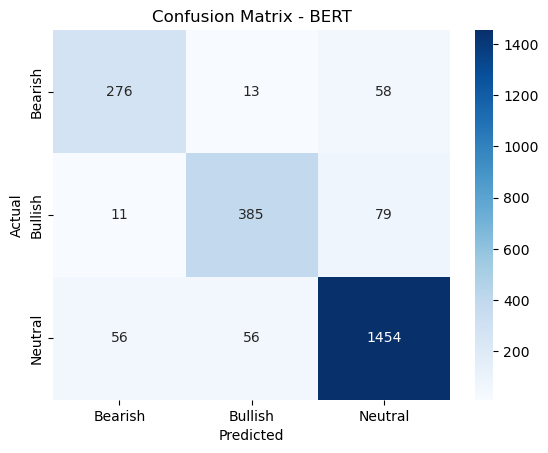

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
pred_output = trainer.predict(valid_dataset)
y_pred = torch.argmax(torch.tensor(pred_output.predictions), dim=1).numpy()
y_true = pred_output.label_ids

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Bearish", "Bullish", "Neutral"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bearish", "Bullish", "Neutral"], yticklabels=["Bearish", "Bullish", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT")
plt.savefig("confusion_bert_based.png", dpi=300)
plt.show()
